<a href="https://www.kaggle.com/code/pirajeshmr/adobe-gensolve?scriptVersionId=192122761" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**CURVETOPIA**

This is our submission for the round 2 of adobe gensolve.

**Required files and images are to be inputted accordingly in the cells as required in appropriate places for testing.**

We read and plot the CSVs containing the polylines that represent the doodles as given in the problem statement

In [60]:
def read_csv(csv_path):
    np_path_XYs=np.genfromtxt(csv_path,delimiter=',')
    path_XYs=[]
    for i in np.unique(np_path_XYs[:,0]):
        npXYs=np_path_XYs[np_path_XYs[:,0]==i][:,1:]
        XYs=[]
        for j in np.unique(npXYs[:,0]):
            XY=npXYs[npXYs[:,0]==j][:,1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs


def plot_polylines(paths_XYs, save_path=None):
    fig, ax = plt.subplots(tight_layout=True, figsize=(4, 4))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2, label=f'Polyline {i}')
    ax.set_aspect("equal")
    ax.axis('off')

    if save_path:
        plt.savefig(save_path, format='jpg')

    plt.show()

The below set of functions are for regularizing a given doodle. 
* **function fit_line** : fits a given line to a set of 2d points using linear regression by extracting x and y coords from points array
* **function draw_shape** : sketches various shapes on a blank image by using points as the core param
* **function getShapeName** : classify the shape based on the number of vertices in the contour approximation

further explanation can be seen in the cells

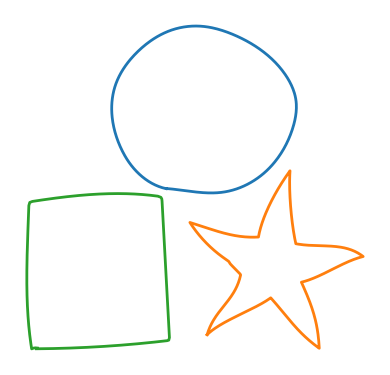

rectangle
rectangle
polygon
polygon
circle
circle


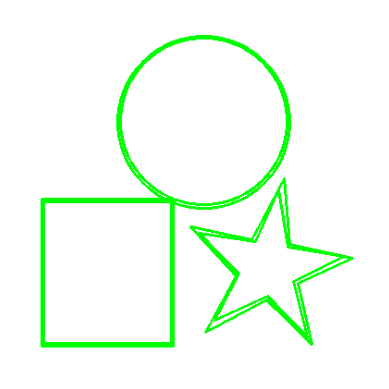

True

In [76]:
def fit_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept

    return slope, intercept

def draw_shape(image, shape_type, points):
    if shape_type == "line":
        pt1 = tuple(points[0][0])
        pt2 = tuple(points[1][0])
        cv2.line(image, pt1, pt2,(0, 255,0), 2)
    elif shape_type == "rectangle":
        x, y, w, h = cv2.boundingRect(points)
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image, top_left, bottom_right, (0,255,0), 2)
    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, (0,255,0), 2)
    elif shape_type == "polygon":
        cv2.polylines(image, [points], isClosed=True, color=(0,255,0), thickness=2)


        
## READING CSV. INPUT YOUR CSV FILE HERE

img = read_csv('/kaggle/input/adobe-csvs/isolated.csv') 



plot_polylines(img, 'frag0.jpg')
img = cv2.imread('frag0.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) ##converting the img to grey scale for edgw detection

# _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(gray, 50, 150)  ##Canny edge detection
kernel = np.ones((4, 4), np.uint8) 
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel) ##Applies a closing operation to fill small gaps in the edges
contour, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) ##Finds the contours in the processed edge image

def getShapeName(approx):
    if len(approx) == 2:
        shape_name = "line"
    elif len(approx) == 3:
        shape_name = "triangle"
    elif len(approx) == 4 or len(approx) == 5:
        shape_name = "rectangle"
    elif len(approx) > 12:
        shape_name = "circle"
    else:
        shape_name = "polygon"
    return shape_name

## the below lines of code, for each contour, approximates the contour to a polygon, classifies the shape, and draws it
shape_image = np.ones_like(img)*255
circles = []
if circles:
    largest_circle = max(circles, key=lambda c: c[2])
    center = (int(largest_circle[0]), int(largest_circle[1]))
    radius = int(largest_circle[2])
    cv2.circle(shape_image, center, radius, (0,255,0), 2)
for cont in contour:
    epsilon = 0.0095 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    shape_name = getShapeName(approx)
    print(shape_name)
    if shape_name == 'rectangle':
        draw_shape(shape_image, 'rectangle', approx)
    elif shape_name == 'circle':
        draw_shape(shape_image, 'circle', approx)
    elif shape_name == 'polygon':
        draw_shape(shape_image, 'polygon', approx)



plt.imshow(shape_image)
plt.axis('off')
plt.show()
cv2.imwrite('resultant_shapes1.jpg', shape_image) ##img is saved

The below set of codes are for finding symmetry in an image
* **function compute_symmetry_score** : Computes how well a set of points align with a given line, used to measure symmetry.
* **function detect_symmetry** : Detects possible symmetry axes in a set of points usign centroid calculation
* **function draw_symmetry_axes** : Draws detected symmetry axes, if any, on the image.

further explanation in below cells


Detected Symmetries for Contour 1: []


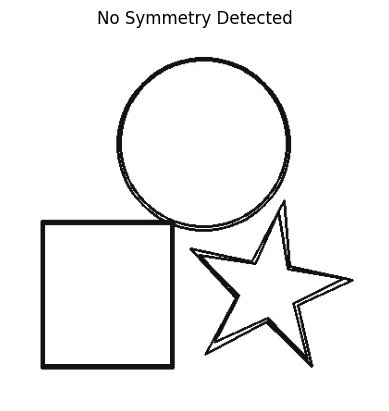

In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fit_line(points):
    A = np.vstack([points[:, 0], np.ones(len(points))]).T
    m, c = np.linalg.lstsq(A, points[:, 1], rcond=None)[0]
    return m, c

def compute_symmetry_score(line_params, points):
    m, c = line_params
    distances = np.abs(m * points[:, 0] - points[:, 1] + c) / np.sqrt(m ** 2 + 1)
    return np.mean(distances)

def detect_symmetry(points):
    symmetric_lines = []

    if len(points) < 2:
        return symmetric_lines

    # Calculate centroid
    x_mean = np.mean(points[:, 0])
    y_mean = np.mean(points[:, 1])

    # Vertical Symmetry
    vertical_line = (1, -x_mean)
    vertical_symmetry_score = compute_symmetry_score(vertical_line, points)
    if vertical_symmetry_score < 10:
        symmetric_lines.append(("Vertical", vertical_line))

    # Horizontal Symmetry
    horizontal_line = (0, -y_mean)
    horizontal_symmetry_score = compute_symmetry_score(horizontal_line, points)
    if horizontal_symmetry_score < 10:
        symmetric_lines.append(("Horizontal", horizontal_line))

    # Diagonal Symmetry (45-degree)
    m_diag_45 = 1
    c_diag_45 = -y_mean - m_diag_45 * x_mean
    diag_45_symmetry_score = compute_symmetry_score((m_diag_45, c_diag_45), points)
    if diag_45_symmetry_score < 10:
        symmetric_lines.append(("Diagonal 45-degree", (m_diag_45, c_diag_45)))

    # Diagonal Symmetry (135-degree)
    m_diag_135 = -1
    c_diag_135 = y_mean - m_diag_135 * x_mean
    diag_135_symmetry_score = compute_symmetry_score((m_diag_135, c_diag_135), points)
    if diag_135_symmetry_score < 10:
        symmetric_lines.append(("Diagonal 135-degree", (m_diag_135, c_diag_135)))


    return symmetric_lines

def draw_symmetry_axes(img, points, symmetries):
    img_copy = img.copy()
    h, w = img.shape[:2]
    
    # Draw symmetry axes
    for symmetry in symmetries:
        if symmetry[0] == "Vertical":
            x = int(-symmetry[1])
            cv2.line(img_copy, (x, 0), (x, h), (0, 255, 0), 2)
        elif symmetry[0] == "Horizontal":
            y = int(-symmetry[1])
            cv2.line(img_copy, (0, y), (w, y), (0, 255, 0), 2)
        elif symmetry[0] == "Diagonal 45-degree":
            m, c = symmetry[1]
            cv2.line(img_copy, (0, int(c)), (w, int(m * w + c)), (0, 255, 0), 2)
        elif symmetry[0] == "Diagonal 135-degree":
            m, c = symmetry[1]
            cv2.line(img_copy, (0, int(c)), (w, int(-m * w + c)), (0, 255, 0), 2)
    
    return img_copy

def main():
    # Load image and find contours
    img = cv2.imread('/kaggle/working/resultant_shapes1.jpg', cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for i, contour in enumerate(contours):
        contour = contour.reshape(-1, 2)
        symmetries = detect_symmetry(contour)
        print(f"Detected Symmetries for Contour {i+1}:", symmetries)
        
        # Draw symmetry axes
        img_with_axes = draw_symmetry_axes(img, contour, symmetries)
        
        # Show the result with Matplotlib
        plt.imshow(img_with_axes, cmap='gray')
        plt.title('Symmetry' if symmetries else 'No Symmetry Detected')
        plt.axis('off')  # Hide axes
        plt.show()

if __name__ == "__main__":
    main()


We have attempted to handle occlusion using the stable diffusion inpainting pipeline in the below cells by converting a given image (not svg format) to a mask and passing both the original image and the mask to the pipeline with a prompt with hopes of handling occlusion

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot_polylines(paths_XYs, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2, label=f'Polyline {i}')
    ax.set_aspect("equal")
    ax.axis('off')

    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight', pad_inches=0)
    plt.show()

def convert_to_image(csv_path, image_path):
    paths_XYs = read_csv(csv_path)
    plot_polylines(paths_XYs, save_path=image_path)

##converting svg to png or any other format as needed

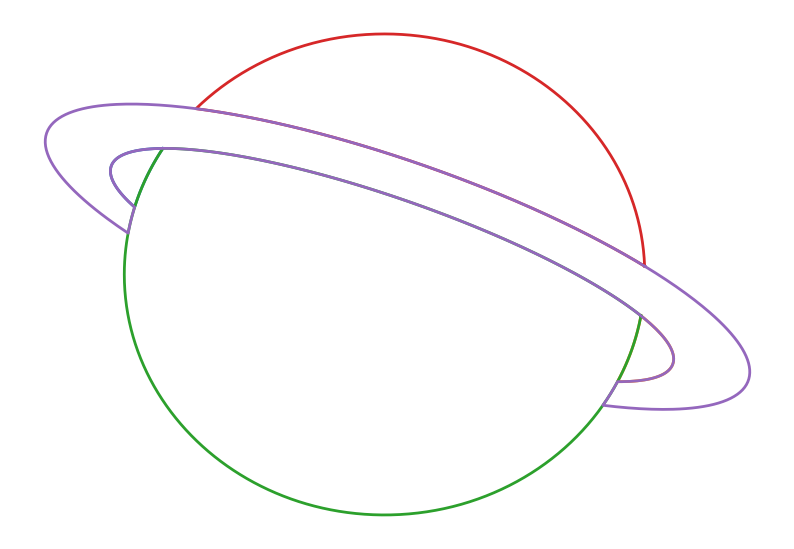

In [96]:
convert_to_image('/kaggle/input/adobe-csvs/occlusion2.csv', '/kaggle/working/occlusion2.png')

In [95]:
pip install diffusers transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Explanation of codes can be seen in the cells

In [97]:
import cv2
import numpy as np

def create_mask(image_path, mask_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Create a binary mask (e.g., where occlusions are white)
    _, binary_mask = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)

    # Convert binary mask to RGB
    mask_rgb = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2RGB)
    
    # Save the mask
    cv2.imwrite(mask_path, mask_rgb)

if __name__ == "__main__":
    create_mask('/kaggle/working/occlusion2.png', '/kaggle/working/mask.png')


In [98]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import numpy as np

def stable_diffusion_inpaint(image_path, mask_path, output_path):
    # Load the image and mask
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("RGB")

    # Load the Stable Diffusion model for inpainting
    pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
    pipe.to("cuda")  # Use GPU if available

    # Perform inpainting
    result = pipe(prompt="Reconstruct the obstructed parts", image=image, mask_image=mask).images[0]

    result.save(output_path)

if __name__ == "__main__":
    stable_diffusion_inpaint('/kaggle/working/occlusion2.png', '/kaggle/working/mask.png', '/kaggle/working/reconstructed_image.png')


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-08-11 15:12:11.912167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 15:12:11.912281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 15:12:12.039322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604

  0%|          | 0/50 [00:00<?, ?it/s]

The resultant image is saved to the working directory
